In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

np.random.seed(40)

In [18]:
from google.colab import drive
drive.mount('/content/drive') ## For Colab
%cd '/content/drive/MyDrive/Github/project_ddareungi'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Github/project_ddareungi


In [19]:
# Data Load
df_train = pd.read_csv('train.csv')
df_train = df_train.iloc[:,1:]
df_train.columns = ['hour', 'temp', 'precip',
       'windspeed', 'humidity', 'visibility',
       'ozone', 'pm10', 'pm2_5', 'count']
df_X = df_train[df_train.columns.drop('count')]
df_y = df_train['count'].values

X_train, X_val, y_train, y_val = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

In [20]:
# # Visualize Pipeline
from sklearn import set_config

set_config(display="diagram")

In [21]:
# Data Preprocessing
numeric_features = list(df_X.columns.drop(['precip','hour']))
numeric_transformer = Pipeline(
    steps=[("imputer",SimpleImputer(strategy='median')),("scaler",StandardScaler())]
)
hour_feature = ['hour']
hour_transformer = Pipeline(
    steps=[("imputer",SimpleImputer(strategy='most_frequent')),('scaler',StandardScaler(with_std=False))]
 ) # hour은 standardscaler에서 표준편차로 나누는 것은 제외함.
hour_transformer_oh = OneHotEncoder(handle_unknown='ignore',sparse=False) # hour을 onehotencoding으로 처리

categorical_features = ['precip']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ('hour', hour_transformer, hour_feature),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [ ]:
# Tree Regressor
from sklearn.tree import DecisionTreeRegressor
tree_reg = Pipeline(
    steps=[("preprocessor",preprocessor),
    ("tree",DecisionTreeRegressor(criterion="squared_error"))]
)
tree_reg.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'windspeed',
                                                   'humidity', 'visibility',
                                                   'ozone', 'pm10', 'pm2_5']),
                                                 ('hour',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler(with_std=False))]),
                                                  ['hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['precip'])])),
                ('tree', DecisionTreeRegressor())])

In [ ]:
# Tree Info and Validation RMSE
tree_res = tree_reg.named_steps['tree']
tree_res.get_depth() # 20
tree_res.get_n_leaves() # 967
tree_pred = tree_reg.predict(X_val)
np.sqrt(mean_squared_error(y_val, tree_pred)).round(3) # 50.643


50.643

In [ ]:
# Check whether Overfitted with Cross-Validation
from tqdm import * # Progress-bar
from sklearn.model_selection import GridSearchCV
params = {'max_features':("sqrt","log2","auto"), "max_depth" : list(range(2, 41, 2))}

# GridSearch Algorithm
N_comb = len(params['max_features']) * len(params['max_depth'])
with tqdm(total=N_comb) as pbar:
    df = []
    for feat in params['max_features']:
        scores = []
        for d in params['max_depth']:
            reg_i = Pipeline(
                steps=[('preprocessor',preprocessor),('tree',DecisionTreeRegressor(max_features=feat,max_depth=d))]
            )
            reg_i.fit(X_train,y_train)
            pred_i = reg_i.predict(X_val)
            score_i = np.sqrt(mean_squared_error(y_val, pred_i)).round(3)
            scores.append(score_i)
            pbar.update()
        df.append(scores)
res = pd.DataFrame(df, index=params['max_features'], columns=params['max_depth']).T

100%|██████████| 60/60 [00:01<00:00, 35.15it/s]


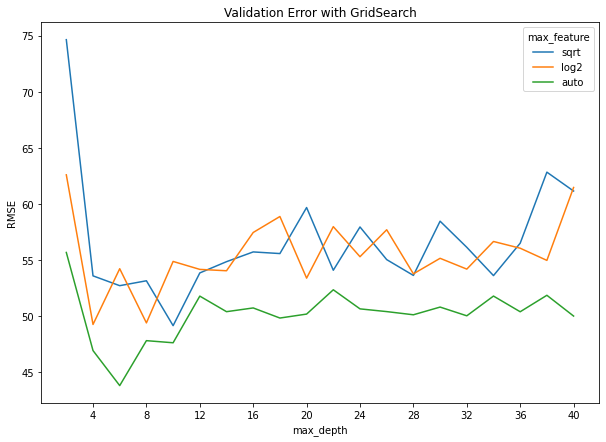

In [ ]:
# Plot the result of GridSearch
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(res.index, res['sqrt'], label = 'sqrt')
plt.plot(res.index, res['log2'], label = 'log2')
plt.plot(res.index, res['auto'], label = 'auto')
plt.legend(title = "max_feature", loc = 'upper right')
plt.xticks(range(4,44,4))
ax.set(xlabel="max_depth", ylabel="RMSE", title="Validation Error with GridSearch")
plt.savefig("plots/GridSearch_Tree.png", facecolor = 'white', transparent = False)

100%|██████████| 60/60 [00:02<00:00, 23.85it/s]


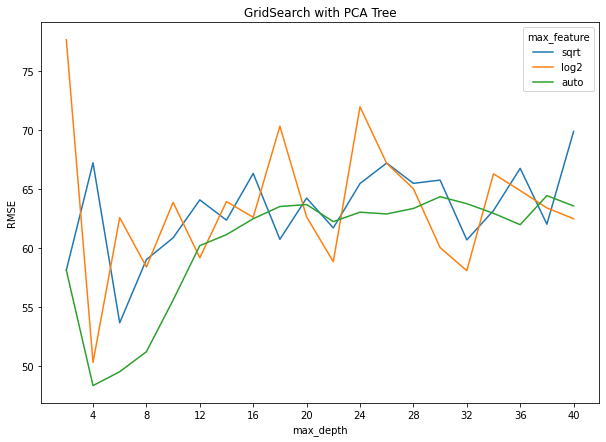

In [ ]:
# GridSearch with PCA Tree
from sklearn.decomposition import PCA

params = {'max_features':("sqrt","log2","auto"), "max_depth" : list(range(2, 41, 2))}
N_comb = len(params['max_features']) * len(params['max_depth'])
with tqdm(total=N_comb) as pbar:
    df = []
    for feat in params['max_features']:
        scores = []
        for d in params['max_depth']:
            reg_i = Pipeline(
                steps=[('preprocessor',preprocessor),('pca',PCA(n_components=3)),('tree',DecisionTreeRegressor(max_features=feat,max_depth=d))]
            )
            reg_i.fit(X_train,y_train)
            pred_i = reg_i.predict(X_val)
            score_i = np.sqrt(mean_squared_error(y_val, pred_i)).round(3)
            scores.append(score_i)
            pbar.update()
        df.append(scores)
res = pd.DataFrame(df, index=params['max_features'], columns=params['max_depth']).T

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(res.index, res['sqrt'], label = 'sqrt')
plt.plot(res.index, res['log2'], label = 'log2')
plt.plot(res.index, res['auto'], label = 'auto')
plt.legend(title = "max_feature", loc = 'upper right')
plt.xticks(range(4,44,4))
ax.set(xlabel="max_depth", ylabel="RMSE", title="GridSearch with PCA Tree")
plt.savefig("plots/GridSearch_TreewithPCA.png", facecolor = 'white', transparent = False)

In [ ]:
# Three Models : For each max_feature, the argmin max_depth
idx_1 = res.index[np.argmin(res['auto'])]
idx_2 = res.index[np.argmin(res['log2'])]
idx_3 = res.index[np.argmin(res['sqrt'])]


tree_pca_1 = Pipeline(
    steps=[('preprocessor',preprocessor),
        ('pca', PCA(n_components=3)),
        ('tree',DecisionTreeRegressor(max_features='auto',max_depth=idx_1))]
)
tree_pca_2 = Pipeline(
    steps=[('preprocessor',preprocessor),
        ('pca', PCA(n_components=3)),
        ('tree',DecisionTreeRegressor(max_features='log2',max_depth=idx_2))]
)
tree_pca_3 = Pipeline(
    steps=[('preprocessor',preprocessor),
        ('pca', PCA(n_components=3)),
        ('tree',DecisionTreeRegressor(max_features='sqrt',max_depth=idx_3))]
)
tree_pca_1.fit(X_train, y_train)
tree_pca_2.fit(X_train, y_train)
tree_pca_3.fit(X_train, y_train)

pca = tree_pca_1[0:2] # Pipeline until PCA
xs_1, ys_1 = zip(*sorted(zip(pca.transform(X_val)[:,0],tree_pca_1.predict(X_val))))
xs_2, ys_2 = zip(*sorted(zip(pca.transform(X_val)[:,0],tree_pca_2.predict(X_val))))
xs_3, ys_3 = zip(*sorted(zip(pca.transform(X_val)[:,0],tree_pca_3.predict(X_val))))


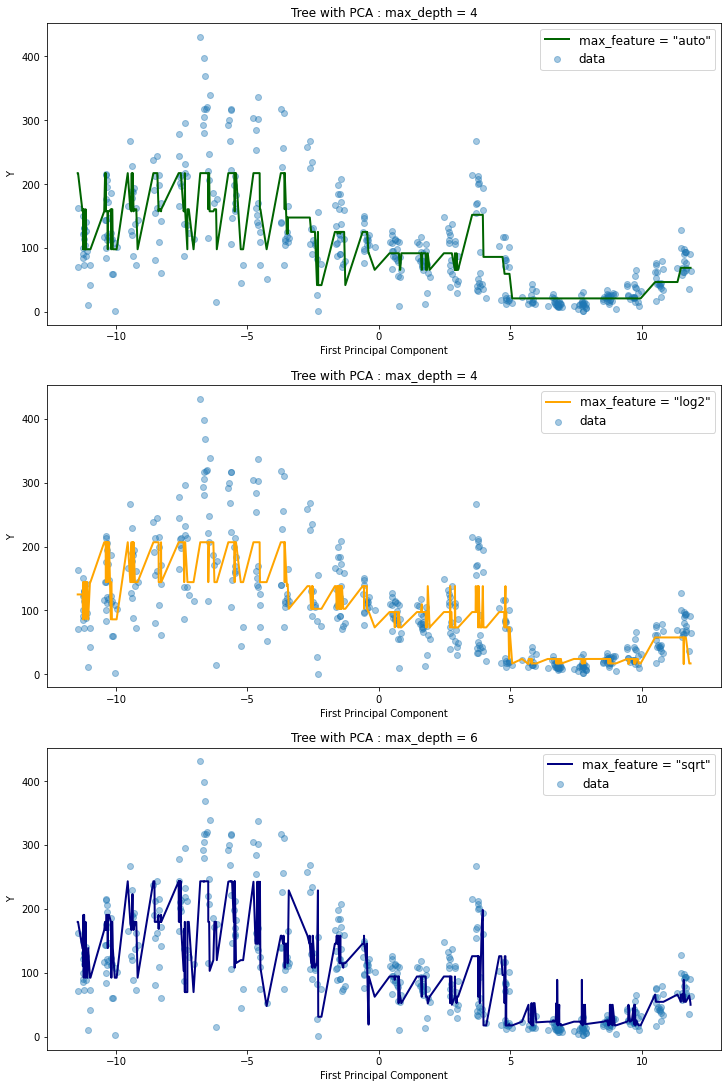

In [ ]:
# Compare three Local_Minimum RMSE spot
# Projeted on the first Principal Component

# Plot
fig, axes = plt.subplots(3,1,figsize=(10,15), constrained_layout=True)
axes[0].scatter(pca.transform(X_val)[:,0], y_val, alpha=0.4, label='data')
axes[0].plot(xs_1, ys_1, label = 'max_feature = "auto"', color = "darkgreen", linewidth = 2)
axes[0].legend(fontsize = 12, loc = 'upper right')
axes[0].set(xlabel = "First Principal Component", ylabel="Y",title=f"Tree with PCA : max_depth = {idx_1}")

axes[1].scatter(pca.transform(X_val)[:,0], y_val, alpha=0.4, label='data')
axes[1].plot(xs_2, ys_2, label = 'max_feature = "log2"', color = "orange", linewidth = 2)
axes[1].legend(fontsize = 12, loc = 'upper right')
axes[1].set(xlabel = "First Principal Component", ylabel="Y",title=f"Tree with PCA : max_depth = {idx_2}")

axes[2].scatter(pca.transform(X_val)[:,0], y_val, alpha=0.4, label='data')
axes[2].plot(xs_3, ys_3, label = 'max_feature = "sqrt"', color = "navy", linewidth = 2)
axes[2].legend(fontsize = 12, loc = 'upper right')
axes[2].set(xlabel = "First Principal Component", ylabel="Y",title=f"Tree with PCA : max_depth = {idx_3}")


plt.savefig("plots/tree_pca.png", transparent=False, facecolor='white')

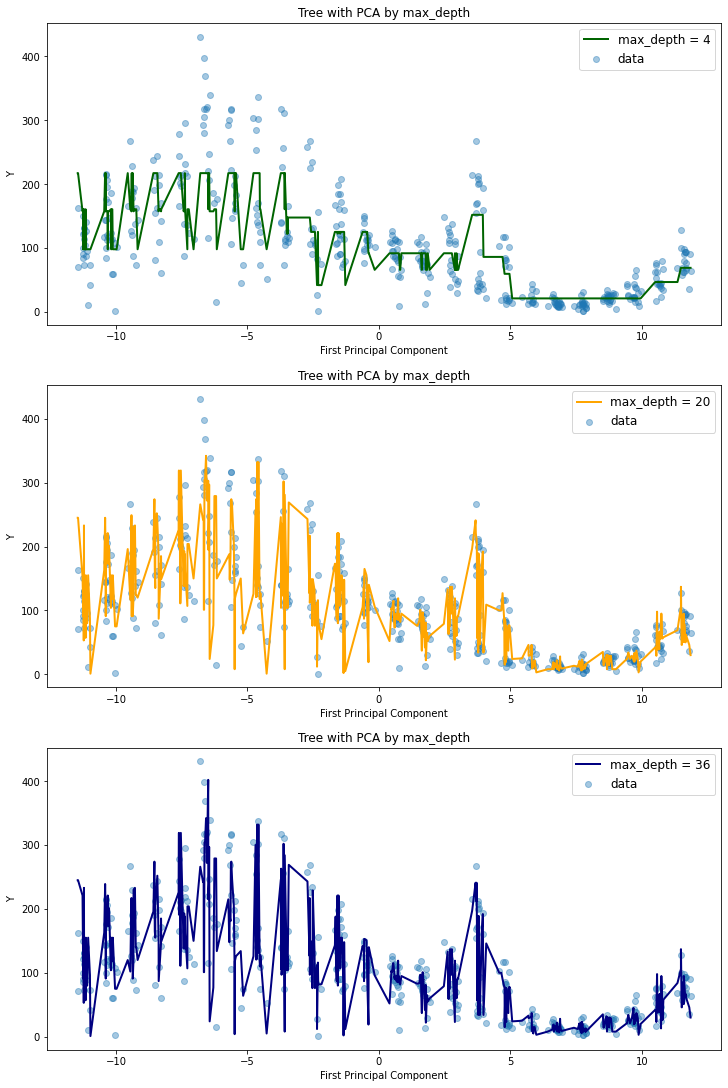

In [ ]:
# Same Feature with Different Depth

tree_pca_4 = Pipeline(
    steps=[('preprocessor',preprocessor),
        ('pca', PCA(n_components=3)),
        ('tree',DecisionTreeRegressor(max_features='auto',max_depth=4))]
)
tree_pca_5 = Pipeline(
    steps=[('preprocessor',preprocessor),
        ('pca', PCA(n_components=3)),
        ('tree',DecisionTreeRegressor(max_features='auto',max_depth=20))]
)
tree_pca_6 = Pipeline(
    steps=[('preprocessor',preprocessor),
        ('pca', PCA(n_components=3)),
        ('tree',DecisionTreeRegressor(max_features='auto',max_depth=36))]
)
tree_pca_4.fit(X_train, y_train)
tree_pca_5.fit(X_train, y_train)
tree_pca_6.fit(X_train, y_train)

pca = tree_pca_4[0:2] # Pipeline until PCA
xs_4, ys_4 = zip(*sorted(zip(pca.transform(X_val)[:,0],tree_pca_4.predict(X_val))))
xs_5, ys_5 = zip(*sorted(zip(pca.transform(X_val)[:,0],tree_pca_5.predict(X_val))))
xs_6, ys_6 = zip(*sorted(zip(pca.transform(X_val)[:,0],tree_pca_6.predict(X_val))))

fig, axes = plt.subplots(3,1,figsize=(10,15), constrained_layout=True)
axes[0].scatter(pca.transform(X_val)[:,0], y_val, alpha=0.4, label='data')
axes[0].plot(xs_4, ys_4, label = 'max_depth = 4', color = "darkgreen", linewidth = 2)
axes[0].legend(fontsize = 12, loc = 'upper right')
axes[0].set(xlabel = "First Principal Component", ylabel="Y",title=f"Tree with PCA by max_depth")

axes[1].scatter(pca.transform(X_val)[:,0], y_val, alpha=0.4, label='data')
axes[1].plot(xs_5, ys_5, label = 'max_depth = 20', color = "orange", linewidth = 2)
axes[1].legend(fontsize = 12, loc = 'upper right')
axes[1].set(xlabel = "First Principal Component", ylabel="Y",title=f"Tree with PCA by max_depth")

axes[2].scatter(pca.transform(X_val)[:,0], y_val, alpha=0.4, label='data')
axes[2].plot(xs_6, ys_6, label = 'max_depth = 36', color = "navy", linewidth = 2)
axes[2].legend(fontsize = 12, loc = 'upper right')
axes[2].set(xlabel = "First Principal Component", ylabel="Y",title=f"Tree with PCA by max_depth")


plt.savefig("plots/tree_pca_by_depth.png", transparent=False, facecolor='white')

In [26]:
# GBDT with GridsearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# RMSE def for Gridsearch Scoring
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return(np.sqrt(mse))
rmse_score = make_scorer(rmse, greater_is_better=False)
# Pipeline Model
tree_gbm = Pipeline([
("preprocessor",preprocessor),("gbm",GradientBoostingRegressor(loss='squared_error',max_features='auto'))
])

In [ ]:
# Gridsearch
param_grid = {
    'gbm__n_estimators' : 10 * np.logspace(base=2, start=0, stop=5, num=6).astype(int),
    'gbm__max_depth' : np.linspace(4,32,8).astype(int)
}
search = GridSearchCV(
    tree_gbm, param_grid, verbose = 5, n_jobs= 5, scoring = rmse_score
)
# search.fit(X_train, y_train)

In [ ]:
# Result to csv
# search_res = pd.DataFrame(search.cv_results_)
# search_res.to_csv('logs/tree_gbm_res.csv') ## At Colab

In [ ]:
# Read search_res
search_res = pd.read_csv("logs/tree_gbm_res.csv", index_col=0)
search_res.head(1).round(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gbm__max_depth,param_gbm__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.249,0.063,0.061,0.016,4,10,"{'gbm__max_depth': 4, 'gbm__n_estimators': 10}",-53.869,-45.526,-53.144,-51.671,-48.405,-50.523,3.125,17


In [ ]:
search_res.mean_test_score

0    -50.522980
1    -43.070768
2    -40.612367
3    -40.248471
4    -40.317855
5    -40.198517
6    -47.542624
7    -42.106671
8    -40.955961
9    -40.580756
10   -40.782514
11   -41.111888
12   -51.072769
13   -48.516310
14   -49.047405
15   -49.076189
16   -49.123783
17   -49.289455
18   -52.199407
19   -50.795051
20   -52.750467
21   -53.163488
22   -53.188113
23   -53.456049
24   -52.092707
25   -51.131148
26   -52.975395
27   -53.253491
28   -53.353660
29   -53.371160
30   -52.108875
31   -51.180856
32   -52.992651
33   -53.046073
34   -53.387640
35   -53.651212
36   -51.904131
37   -51.567404
38   -52.991943
39   -53.554355
40   -53.393353
41   -53.669032
42   -51.969207
43   -51.306392
44   -52.814038
45   -53.557779
46   -53.781587
47   -53.348309
Name: mean_test_score, dtype: float64

In [ ]:
scores_mean = np.array(-search_res['mean_test_score']).reshape(8,6)
pd.DataFrame(scores_mean)
scores_mean[:,0]

array([50.52298013, 47.54262379, 51.07276881, 52.19940676, 52.09270701,
       52.10887483, 51.90413147, 51.9692067 ])

In [ ]:
param_grid['gbm__max_depth']

array([ 4,  8, 12, 16, 20, 24, 28, 32])

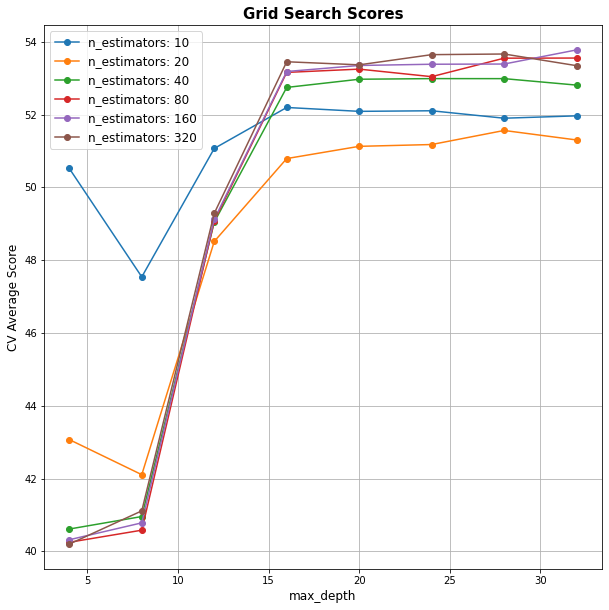

In [ ]:
# Plot search_res
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, greater_is_better):
    # Get Test Scores Mean and std for each grid search
    if greater_is_better: # greater_is_better = False면 score 값이 음수임
        scores_mean = cv_results['mean_test_score']
    else:
        scores_mean = -cv_results['mean_test_score']

    scores_mean = np.array(scores_mean).reshape(len(grid_param_1),len(grid_param_2))

    # Plot Grid search scores
    fig, ax = plt.subplots(1,1, figsize = (10,10))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[:,idx], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=15, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=12)
    ax.set_ylabel('CV Average Score', fontsize=12)
    ax.legend(loc="best", fontsize=12)
    ax.grid('on')
    plt.savefig('plots/tree_gbm_gridsearchcv.png', facecolor='white', transparent=False)

plot_grid_search(search_res, 
    param_grid['gbm__max_depth'],
    param_grid['gbm__n_estimators'],
    'max_depth', 'n_estimators', greater_is_better=False)

In [ ]:
# Best_params
best_params = search_res.loc[search_res['rank_test_score']==1,["param_gbm__max_depth","param_gbm__n_estimators"]]
gbdt_best = Pipeline([
("preprocessor",preprocessor),
("gbm",GradientBoostingRegressor(
    loss='squared_error',max_features='auto',
    max_depth=best_params.iloc[0,0], n_estimators=best_params.iloc[0,1]))
])
gbdt_best.fit(X_train,y_train)
rmse(y_true=y_val, y_pred=gbdt_best.predict(X_val)) # 36.827

36.82740949460516

In [28]:
# RandomForest Regressor
from sklearn.ensemble import RandomForestRegressor
rf_reg = Pipeline(steps=[('preprocessor',preprocessor),('rf',RandomForestRegressor())])
param_grid = {
    'rf__n_estimators' : [50, 100, 200, 400], # number of trees
    'rf__max_features' : ['auto','sqrt'],
    'rf__max_depth' : [5, 10, 15, 20],
    'rf__min_samples_split' : [2, 6, 10],
    'rf__bootstrap' : [True]
}
reg = GridSearchCV(rf_reg, param_grid, verbose=10, n_jobs=-1, scoring=rmse_score)
reg.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'windspeed',
                                                                          'humidity',
                                                                          'visibility',
                                                                          'ozone',
                                                                          'pm10',
                                                                          'pm2_5']),
                                                                        ('hour',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardSc...e))]),
                                                                         ['hour']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['precip'])])),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__bootstrap': [True],
                         'rf__max_depth': [5, 10, 15, 20],
                         'rf__max_features': ['auto', 'sqrt'],
                         'rf__min_samples_split': [2, 6, 10],
                         'rf__n_estimators': [50, 100, 200, 400]},
             scoring=make_scorer(rmse, greater_is_better=False), verbose=10)

In [29]:
# Saving result at Colab
rf_grid_res = pd.DataFrame(reg.cv_results_)
rf_grid_res.to_csv('logs/tree_gbm_res.csv')

In [ ]:
rf